In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
import re
import spacy
from collections import Counter
from xgboost import XGBClassifier


In [8]:
nltk.download('stopwords')

spacy.cli.download("fr_core_news_sm")

nlp = spacy.load('fr_core_news_sm')

file_path = 'projetintegrer.csv'
data = pd.read_csv(file_path)

stop_words = set(stopwords.words('french'))

#clean text
def clean_text(tokens):
    #eemove punctuation and special characters
    tokens = [re.sub(r'\W+', '', token) for token in tokens]
    #convert to lowercase
    tokens = [token.lower() for token in tokens]
    #remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    #lemmatize using spaCy
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    #remove short words
    tokens = [token for token in tokens if len(token) > 2]
    return tokens

#apply cleaning function 
data['Cleaned_Tokens'] = data['Tokenized'].apply(lambda x: clean_text(eval(x)))

#flatten the list of tokens to create a single list of all words
all_words = [word for tokens in data['Cleaned_Tokens'] for word in tokens]

#falculate the frequency of each word
word_freq = Counter(all_words)

#define a threshold for rare words (e.g., words that appear less than 5 times)
threshold = 5

#create a set of rare words
rare_words = {word for word, freq in word_freq.items() if freq < threshold}

#function to remove rare words from tokenized text
def remove_rare_words(tokens):
    return [token for token in tokens if token not in rare_words]

#apply the function to remove rare words
data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(remove_rare_words)
data['Cleaned_Text'] = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
import numpy as np
np.random.seed(42)
data['Sentiment'] = np.random.choice([0, 1], size=len(data))
#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Cleaned_Text'], data['Sentiment'], test_size=0.2, random_state=42)

#adjusting the TF-IDF vectorizer parameters
vectorizer = TfidfVectorizer(
    max_features=5000,  
    ngram_range=(1, 2),  
    max_df=0.95,
    min_df=2
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [38]:
%pip install smote
%pip install imbalanced-learn
%pip install GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement GridSearchCV (from versions: none)
ERROR: No matching distribution found for GridSearchCV


In [11]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
print(data.columns)

Index(['Text', 'Tokenized', 'Cleaned_Tokens', 'Cleaned_Text', 'Sentiment'], dtype='object')


In [13]:
from textblob import TextBlob
import pandas as pd

def classify_sentiment_textblob(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity >= 0.7:
        return 3  # Hyper-positive
    elif polarity > 0.1:
        return 2  # Positive
    elif polarity > -0.1:
        return 1  # Neutral
    elif polarity > -0.7:
        return 0  # Negative
    else:
        return 4  # Hyper-negative

# Assuming 'Cleaned_Tokens' is a list of tokens
data['Sentiment'] = data['Cleaned_Tokens'].apply(lambda x: classify_sentiment_textblob(' '.join(x)))

data.to_csv('data1.csv', index=False)

print(data.head())


                                                Text  \
0                                    lord god angels   
1  blessings iv hated needles young strong im for...   
2  stage 4 small cell stage 5 3 1 2 years took 16...   
3                                      get well soon   
4                                      get well soon   

                                           Tokenized  \
0                          ['lord', 'god', 'angels']   
1  ['blessings', 'iv', 'hated', 'needles', 'young...   
2  ['stage', 'small', 'cell', 'stage', 'years', '...   
3                            ['get', 'well', 'soon']   
4                            ['get', 'well', 'soon']   

                                      Cleaned_Tokens  \
0                                 [lord, god, angel]   
1  [blessing, young, strong, best, thing, positif...   
2  [stage, small, cell, stage, year, took, chemo,...   
3                                  [get, well, soon]   
4                                  [get, well,

In [ ]:
#Vadeer distribution
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE

file_path = 'projetintegrer.csv'
data = pd.read_csv(file_path)


analyzer = SentimentIntensityAnalyzer()

def classify_sentiment_vader(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.7:
        return 3 #++++positive
    elif score['compound'] > 0.1:
        return 2 #positive
    elif score['compound'] > -0.1:
        return 1 #neutral
    elif score['compound'] > -0.7:
        return 0 #neg
    else:
        return 4 #++++++++++++neg
    
data['Sentiment'] = data['Cleaned_Tokens'].apply(lambda x: classify_sentiment_vader(' '.join(eval(x))))

data.to_csv('data2.csv', index=False)

print(data.head())


                                                Text  \
0                                    lord god angels   
1  blessings iv hated needles young strong im for...   
2  stage 4 small cell stage 5 3 1 2 years took 16...   
3                                      get well soon   
4                                      get well soon   

                                           Tokenized  \
0                          ['lord', 'god', 'angels']   
1  ['blessings', 'iv', 'hated', 'needles', 'young...   
2  ['stage', 'small', 'cell', 'stage', 'years', '...   
3                            ['get', 'well', 'soon']   
4                            ['get', 'well', 'soon']   

                                      Cleaned_Tokens  Sentiment  
0                           ['lord', 'god', 'angel']          2  
1  ['blessing', 'hated', 'needle', 'young', 'stro...          3  
2  ['stage', 'small', 'cell', 'stage', 'year', 't...          3  
3                            ['get', 'well', 'soon']          

           Count  Proportion
Sentiment                   
0             96    0.050794
1            718    0.379894
2            864    0.457143
3            203    0.107407
4              9    0.004762


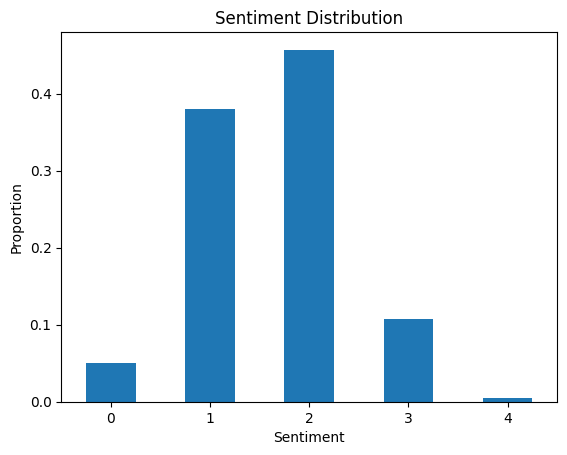

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
#textblob distribution
file_path = 'data1.csv'
data = pd.read_csv(file_path)

sentiment_counts = data['Sentiment'].value_counts().sort_index()
sentiment_proportions = sentiment_counts / len(data)
sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Proportion': sentiment_proportions
})
print(sentiment_summary)

#textblob distribution
sentiment_summary.plot(kind='bar', y='Proportion', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

           Count  Proportion
Sentiment                   
0            172    0.091005
1            229    0.121164
2            516    0.273016
3            877    0.464021
4             96    0.050794


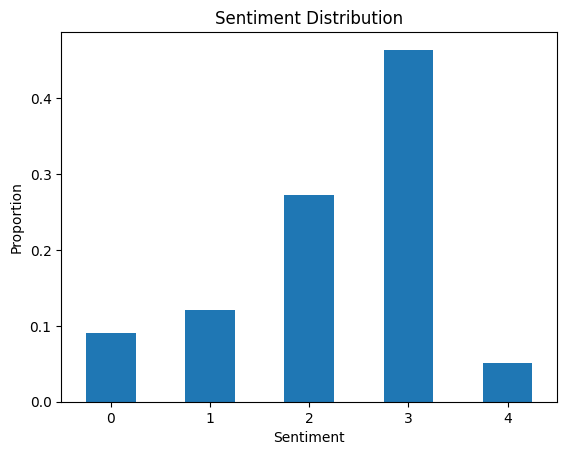

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
#vadeer distribution
file_path = 'data2.csv'
data = pd.read_csv(file_path)

sentiment_counts = data['Sentiment'].value_counts().sort_index()
sentiment_proportions = sentiment_counts / len(data)
sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Proportion': sentiment_proportions
})
print(sentiment_summary)

#vadeer distribution
sentiment_summary.plot(kind='bar', y='Proportion', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

TextBlob Distribution

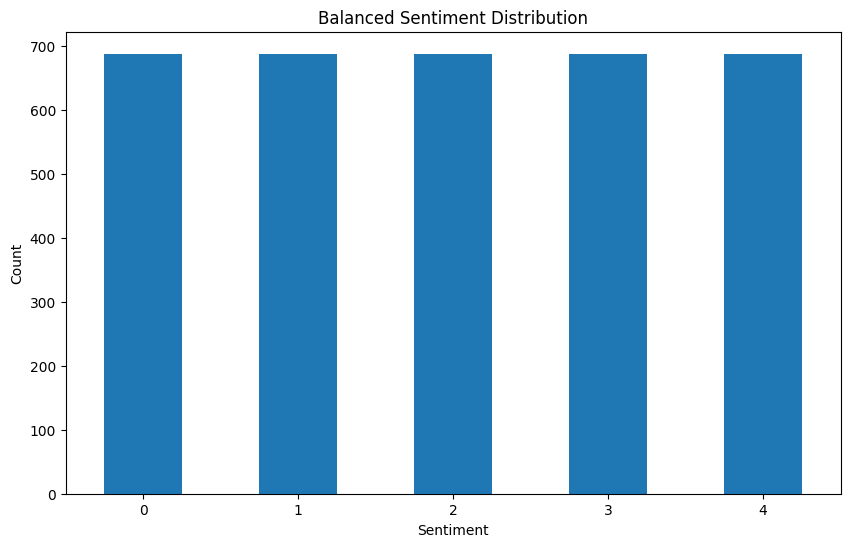

In [29]:
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load data
file_path = 'data1.csv'
data = pd.read_csv(file_path)

# Convert tokenized text back to list of tokens
data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(eval)

# Prepare features and labels
X = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))
y = data['Sentiment']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Define the resampling strategy
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)

# Apply SMOTE to oversample the minority classes
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Combine SMOTE and undersampling
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_smote, y_train_smote)

# Display the distribution after balancing
balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()

plt.figure(figsize=(10, 6))
balanced_counts.plot(kind='bar')
plt.title('Balanced Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

#train the model random forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_balanced, y_train_balanced)
rf_predictions = rf_model.predict(X_test)

#ecaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.828042328042328
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.24      0.31        17
           1       0.82      0.92      0.87       154
           2       0.88      0.82      0.85       176
           3       0.71      0.73      0.72        30
           4       0.00      0.00      0.00         1

    accuracy                           0.83       378
   macro avg       0.57      0.54      0.55       378
weighted avg       0.82      0.83      0.82       378



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

#train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)
nb_predictions = nb_model.predict(X_test)

# evaluate the Naive Bayes model
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 0.6322751322751323
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.53      0.26        17
           1       0.76      0.53      0.62       154
           2       0.81      0.74      0.77       176
           3       0.41      0.63      0.50        30
           4       0.00      0.00      0.00         1

    accuracy                           0.63       378
   macro avg       0.43      0.49      0.43       378
weighted avg       0.73      0.63      0.66       378



In [32]:
from xgboost import XGBClassifier

#train the model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_balanced, y_train_balanced)
xgb_predictions = xgb_model.predict(X_test)

#evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

XGBoost Accuracy: 0.828042328042328
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.29      0.36        17
           1       0.81      0.91      0.86       154
           2       0.87      0.83      0.85       176
           3       0.79      0.73      0.76        30
           4       0.00      0.00      0.00         1

    accuracy                           0.83       378
   macro avg       0.59      0.55      0.57       378
weighted avg       0.82      0.83      0.82       378



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train an SVM model
svm_model = SVC()
svm_model.fit(X_train_balanced, y_train_balanced)
svm_predictions = svm_model.predict(X_test)

# Evaluate the SVM model
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

SVM Accuracy: 0.783068783068783
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        17
           1       0.78      0.87      0.82       154
           2       0.78      0.88      0.83       176
           3       0.88      0.23      0.37        30
           4       0.00      0.00      0.00         1

    accuracy                           0.78       378
   macro avg       0.59      0.41      0.42       378
weighted avg       0.78      0.78      0.75       378



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_balanced, y_train_balanced)
logreg_predictions = logreg_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, logreg_predictions)
report = classification_report(y_test, logreg_predictions)

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Classification Report:")
print(report)

Logistic Regression Accuracy: 0.8095238095238095
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.29      0.34        17
           1       0.79      0.90      0.84       154
           2       0.87      0.82      0.85       176
           3       0.75      0.60      0.67        30
           4       0.00      0.00      0.00         1

    accuracy                           0.81       378
   macro avg       0.57      0.52      0.54       378
weighted avg       0.81      0.81      0.80       378



In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train_balanced, y_train_balanced)
gbm_predictions = gbm_model.predict(X_test)

#evaluate the Gradient Boosting model
accuracy = accuracy_score(y_test, gbm_predictions)
report = classification_report(y_test, gbm_predictions)

print("Gradient Boosting Accuracy:", accuracy)
print("Gradient Boosting Classification Report:")
print(report)

Gradient Boosting Accuracy: 0.8068783068783069
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.35      0.39        17
           1       0.78      0.92      0.84       154
           2       0.92      0.76      0.83       176
           3       0.66      0.77      0.71        30
           4       0.00      0.00      0.00         1

    accuracy                           0.81       378
   macro avg       0.56      0.56      0.55       378
weighted avg       0.81      0.81      0.80       378



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


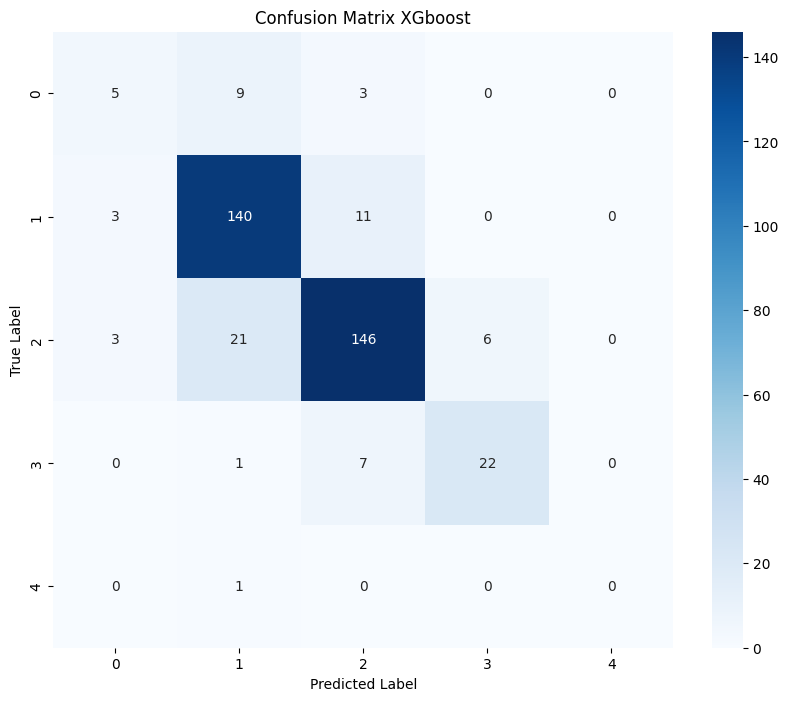

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_predictions, labels=xgb_model.classes_)

cm_df = pd.DataFrame(cm, index=xgb_model.classes_, columns=xgb_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix XGboost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

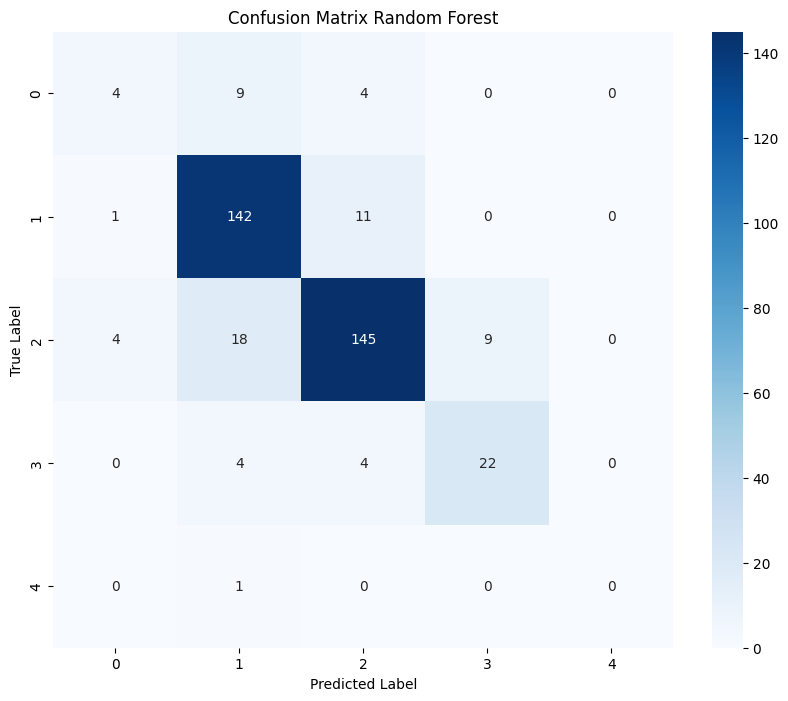

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_predictions, labels=rf_model.classes_)

cm_df = pd.DataFrame(cm, index=rf_model.classes_, columns=rf_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

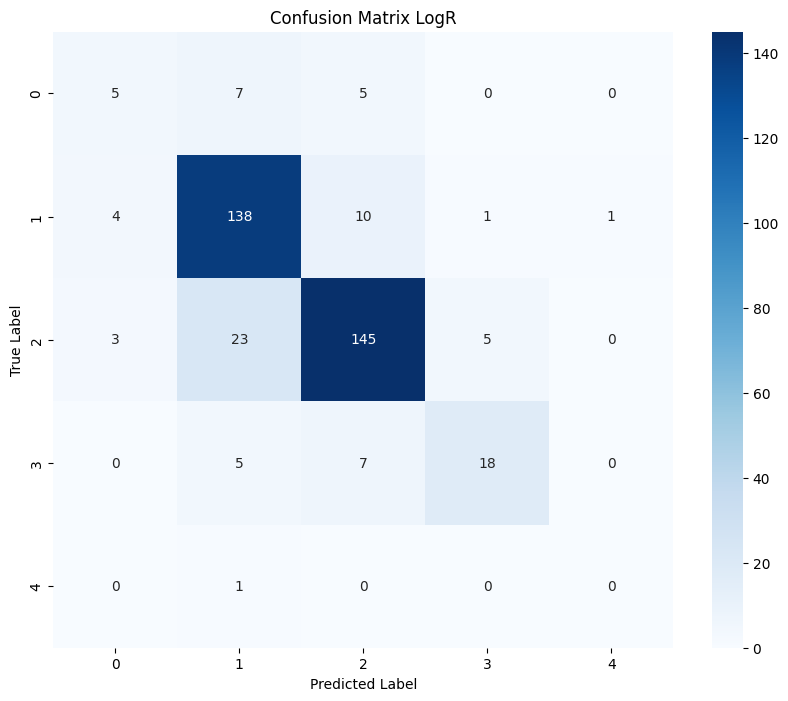

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, logreg_predictions, labels=logreg_model.classes_)

cm_df = pd.DataFrame(cm, index=logreg_model.classes_, columns=logreg_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix LogR')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

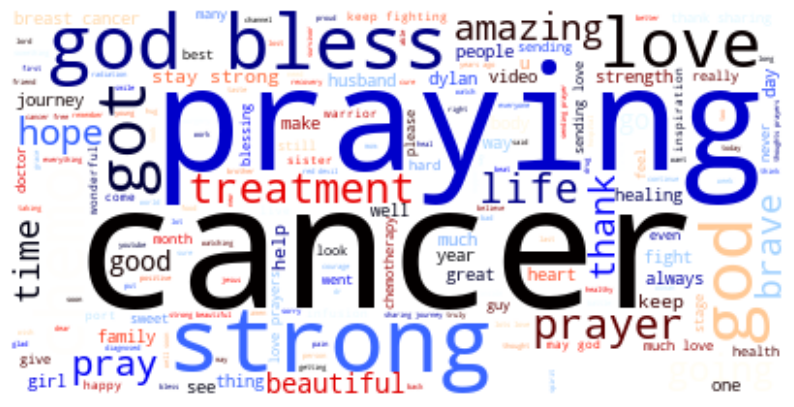

In [24]:
import numpy as np
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('projetintegrer.csv')

# Combine all text from the 'Text' column
text = df['Text'].str.cat(sep=' ')

# Create a set of stopwords and add 'delia' to it
stopwords = set(STOPWORDS)
new_words = {'delia'}
new_stopwords = stopwords.union(new_words)

# Set figure size
plt.rcParams["figure.figsize"] = (10, 10)

# Generate the word cloud
wordcloud = WordCloud(max_font_size=90, max_words=1000, background_color="white", stopwords=new_stopwords, colormap='flag').generate(text)

# Plot the word cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [39]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_balanced, y_train_balanced)

# Best parameters and score
print("Best parameters for XGBoost:", grid_xgb.best_params_)
print("Best score for XGBoost:", grid_xgb.best_score_)

# Evaluate the best model
best_xgb = grid_xgb.best_estimator_
best_xgb_predictions = best_xgb.predict(X_test)
print("Best XGBoost Accuracy:", accuracy_score(y_test, best_xgb_predictions))
print("Best XGBoost Classification Report:")
print(classification_report(y_test, best_xgb_predictions))


Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best score for XGBoost: 0.9261627906976745
Best XGBoost Accuracy: 0.8306878306878307
Best XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.35      0.38        17
           1       0.82      0.91      0.86       154
           2       0.89      0.84      0.86       176
           3       0.81      0.70      0.75        30
           4       0.00      0.00      0.00         1

    accuracy                           0.83       378
   macro avg       0.58      0.56      0.57       378
weighted avg       0.83      0.83      0.83       378



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


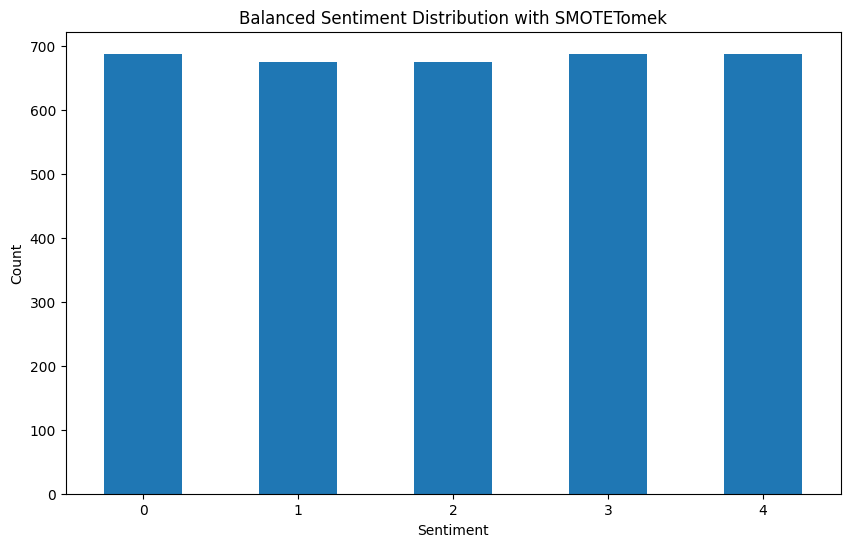

In [40]:
import pandas as pd
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import numpy as np

# Load data
file_path = 'data1.csv'
data = pd.read_csv(file_path)

# Convert tokenized text back to list of tokens
data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(eval)

# Prepare features and labels
X = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))
y = data['Sentiment']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Apply SMOTETomek to balance the training set
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

# Display the distribution after balancing
balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()

plt.figure(figsize=(10, 6))
balanced_counts.plot(kind='bar')
plt.title('Balanced Sentiment Distribution with SMOTETomek')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [41]:
from xgboost import XGBClassifier

#train the model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_balanced, y_train_balanced)
xgb_predictions = xgb_model.predict(X_test)

#evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

XGBoost Accuracy: 0.8174603174603174
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.29      0.33        17
           1       0.81      0.90      0.86       154
           2       0.87      0.82      0.84       176
           3       0.75      0.70      0.72        30
           4       0.00      0.00      0.00         1

    accuracy                           0.82       378
   macro avg       0.56      0.54      0.55       378
weighted avg       0.81      0.82      0.81       378



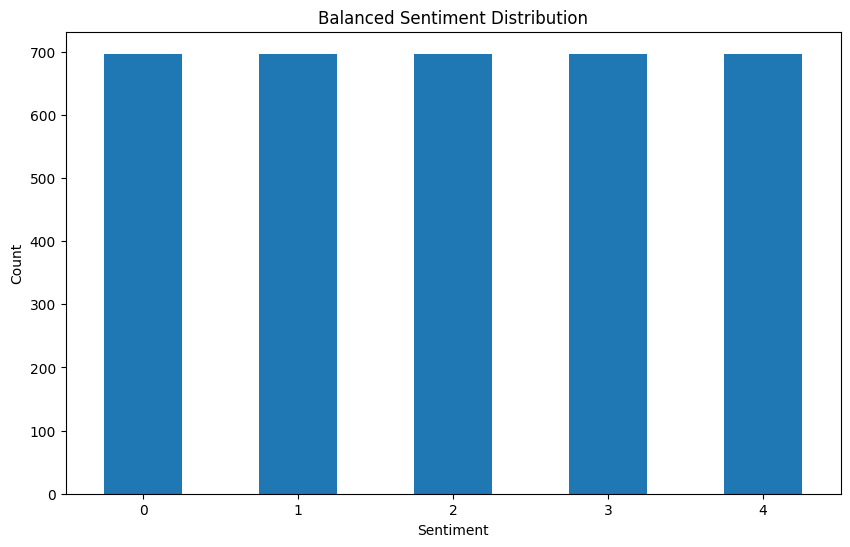

In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load data
file_path = 'data2.csv'
data = pd.read_csv(file_path)

# Convert tokenized text back to list of tokens
data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(eval)

# Prepare features and labels
X = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))
y = data['Sentiment']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Define the resampling strategy
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)

# Apply SMOTE to oversample the minority classes
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Combine SMOTE and undersampling
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_smote, y_train_smote)

# Display the distribution after balancing
balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()

plt.figure(figsize=(10, 6))
balanced_counts.plot(kind='bar')
plt.title('Balanced Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

#train the model random forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_balanced, y_train_balanced)
rf_predictions = rf_model.predict(X_test)

#ecaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.701058201058201
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.48      0.43        33
           1       0.63      0.81      0.71        53
           2       0.60      0.55      0.57        89
           3       0.84      0.84      0.84       180
           4       0.71      0.22      0.33        23

    accuracy                           0.70       378
   macro avg       0.64      0.58      0.58       378
weighted avg       0.71      0.70      0.69       378



In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

#train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)
nb_predictions = nb_model.predict(X_test)

# evaluate the Naive Bayes model
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 0.6005291005291006
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.39      0.33        33
           1       0.88      0.40      0.55        53
           2       0.50      0.39      0.44        89
           3       0.76      0.82      0.79       180
           4       0.23      0.43      0.30        23

    accuracy                           0.60       378
   macro avg       0.53      0.49      0.48       378
weighted avg       0.64      0.60      0.60       378



In [4]:
from xgboost import XGBClassifier

#train the model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_balanced, y_train_balanced)
xgb_predictions = xgb_model.predict(X_test)

#evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

XGBoost Accuracy: 0.708994708994709
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        33
           1       0.63      0.83      0.72        53
           2       0.57      0.57      0.57        89
           3       0.86      0.83      0.85       180
           4       0.58      0.30      0.40        23

    accuracy                           0.71       378
   macro avg       0.63      0.61      0.60       378
weighted avg       0.71      0.71      0.71       378



In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_balanced, y_train_balanced)
logreg_predictions = logreg_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, logreg_predictions)
report = classification_report(y_test, logreg_predictions)

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Classification Report:")
print(report)

Logistic Regression Accuracy: 0.6428571428571429
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.39      0.38        33
           1       0.55      0.70      0.62        53
           2       0.49      0.55      0.52        89
           3       0.87      0.75      0.80       180
           4       0.45      0.39      0.42        23

    accuracy                           0.64       378
   macro avg       0.55      0.56      0.55       378
weighted avg       0.66      0.64      0.65       378



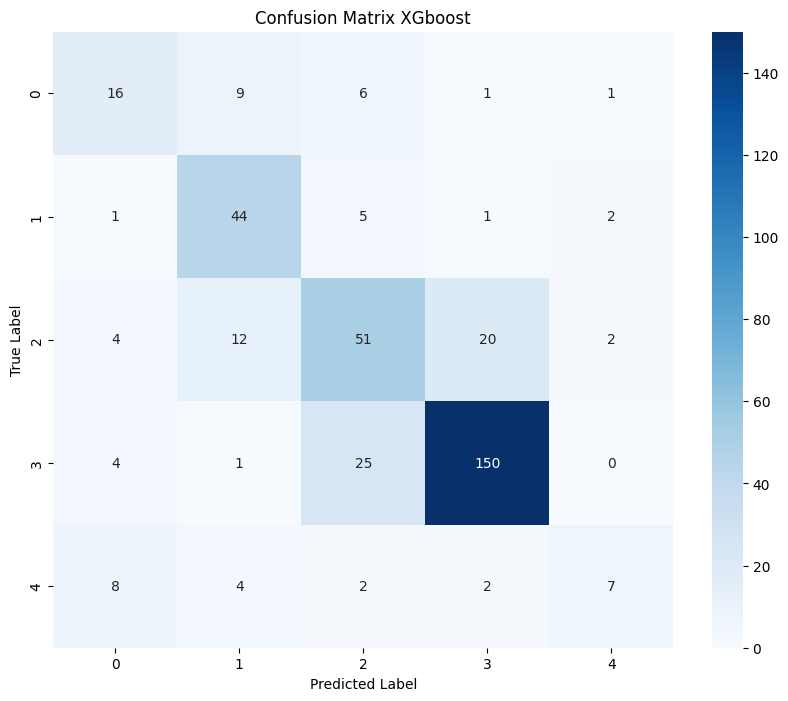

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, xgb_predictions, labels=xgb_model.classes_)

cm_df = pd.DataFrame(cm, index=xgb_model.classes_, columns=xgb_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix XGboost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

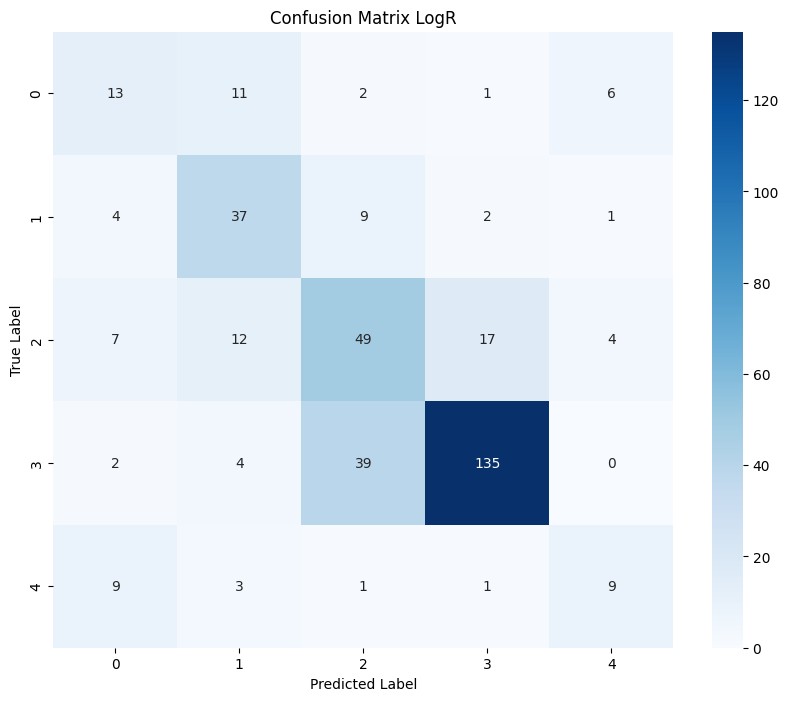

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, logreg_predictions, labels=logreg_model.classes_)

cm_df = pd.DataFrame(cm, index=logreg_model.classes_, columns=logreg_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix LogR')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

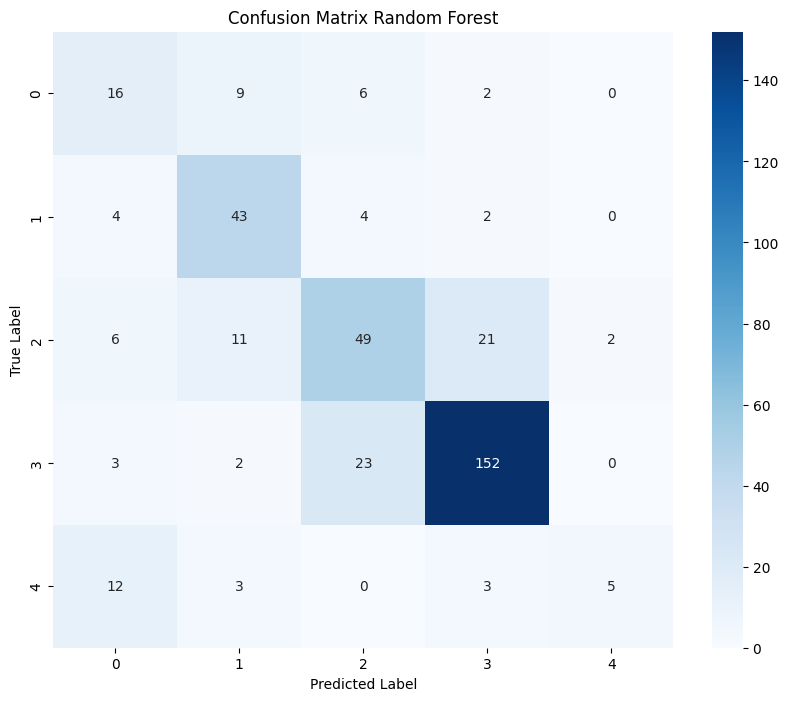

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_predictions, labels=rf_model.classes_)

cm_df = pd.DataFrame(cm, index=rf_model.classes_, columns=rf_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()